In [1]:
"""
Created on Sun Nov. 27 09:46 2022
Last change: December 4, 2022

This program runs the LMS algorithm in Python
Input signal: AR(1) process with a white Gaussian driving noise
Structure: System identification with an input delay line
Unknown system: Nonstationary using the random walk model

The code has been derived from lms_3.py

The code has been optimized using numba to accelerate processing 
The Monte Carlo simulations use parallel processing

Using numba in the GPU seems to be too complex for the possible gain.

@author: bermudez
"""


'\nCreated on Sun Nov. 27 09:46 2022\nLast change: December 4, 2022\n\nThis program runs the LMS algorithm in Python\nInput signal: AR(1) process with a white Gaussian driving noise\nStructure: System identification with an input delay line\nUnknown system: Nonstationary using the random walk model\n\nThe code has been derived from lms_3.py\n\nThe code has been optimized using numba to accelerate processing \nThe Monte Carlo simulations use parallel processing\n\nUsing numba in the GPU seems to be too complex for the possible gain.\n\n@author: bermudez\n'

### Importing the modules necessary for scientific calculations

In [2]:
import numpy as np              # module for working with arrays
import scipy.linalg as linalg   # modulee for linear algebra
import matplotlib.pyplot as plt # module for plotting
import numba as nb              # module numba
import time
#import myfunctions as mf        # module for my own functions

In [3]:
nb.config.NUMBA_NUM_THREADS=64

### Timing execution

In [4]:
t0 = time.time()

### Theoretical model evaluation

In [5]:
# Classical LMS model for Gaussian inputs (Eq. 10.4.28, Manolakis' book)

@nb.njit(fastmath=True)
def classical_model(K0):
    global R, varz, varq, mu, N, iterations
    msdt = np.zeros(iterations)
    emset = np.zeros(iterations)
    K = K0
    msdt[0] = np.trace(K)
    emset[0] = np.trace(R @ K)
    for m in np.arange(1,iterations):
        K = K - mu * (R @ K + K @ R) \
            + mu**2 * (np.trace(R @ K) * R + 2 * R @ K @ R)\
            + mu**2 * varz * R + varq * np.eye(N)
        msdt[m] = np.trace(K)
        emset[m] = np.trace(R @ K)
        
    return msdt, emset    

In [6]:
#classical_model.inspect_types()

In [7]:
# Monte Carlo simulation

@nb.njit(fastmath=True, nogil=True, parallel=True)
def Monte_Carlo(msenb, emsenb, msdnb):
    global runs, SystemResponse, alpha, varx, varz, varq, N, iterations

    for r in nb.prange(runs):               # loop for realizations
        SystemResponsen = SystemResponse.copy()          # Updates the channel response
        W = np.zeros(N)                           # initializes W(0)

        # Input driving noise generation
        X0 = np.sqrt((1-alpha**2)*varx)*np.random.normal(0,1,size=iterations+N+1)
        X1 = np.zeros(iterations+N+1)            # initializes vector of input samples
        X1[0] = X0[0]
        for k in np.arange(1,iterations+N+1):    # AR(1) model
            X1[k] = alpha*X1[k-1] + X0[k]

        # Generation of the measurement noise sequence
        noise = np.sqrt(varz)*np.random.randn(iterations+N)
        
        # Generation of initial input vector
        X = X1[0:N].copy()                         # generates input vector
        X = X[::-1]                           # flips the vector around
        X = np.ascontiguousarray(X)           # to transform X in a contiguous array for numba
        
        # Adaptive algorithm
        for n in np.arange(iterations):
            z = noise[n]                          # generates additive noise sample
            d = np.dot(X,SystemResponsen) + z           # evaluates desired signal
            #d = nb.tensordot(X,SystemResponsen, axes=1).item()
            y = np.dot(X,W)                             # evaluates adaptive filter output
            e = d - y                             # evaluates error signal
            msenb[n] = msenb[n] + e**2                # accumulates e²(n)
            emsenb[n] = emsenb[n] + (e-z)**2          # accumulates (e(n)-z(n))²
            V = W - SystemResponsen               # evaluates weight error vector
            msdnb[n] = msdnb[n] + np.dot(V,V)               # evaluates MSD(n)
            
            # Updating the adaptive weights
            W = W + mu * e * X
            
            # Update of unknown system response
            SystemResponsen = SystemResponsen + np.sqrt(varq) * np.random.randn(N)
            
            # Update input vector
            X = np.concatenate((np.array([X1[n+N]]), X[:-1]))
        
    return msenb, emsenb, msdnb  

In [8]:
#Monte_Carlo.inspect_types()

### Statistical simulation

In [9]:
# Simulation parameters
N = 128                      # number of adaptive coefficients
iterations = 50000          # number of iterations
runs = 100                    # number of Monte Carlo realizations
mu = 5e-4                  # step-size
varx = 1.0                    # variance of the input signal
varz = 1e-6                  # variance of the additive measurement noise
alpha = 0.4                  # correlation parameter for the AR(1) input model
               

# Markov channel fluctuations (choose one)
eta = 0.                         # degree of nonsationarity due to channel changes
varq = (varz*(eta**2))/(N*varx)   # Markov  Channel fluctuations

### Unknown system impulse response

In [10]:
#SystemResponse = mf.raiscos(N,0.,5,0.8)
SystemResponse = np.array(np.random.randn(N))

# Normalization of the system response
SystemResponse = SystemResponse/np.sqrt(SystemResponse.dot(SystemResponse))

#np.save('data/response.npy',SystemResponse) # do it once for all simulations
#SystemResponse = np.load('data/responseraiscos.npy') # use this once the response is saved
#SystemResponse = np.load('data/responsedecay.npy') # use this once the response is saved

### To plot the system response using stem

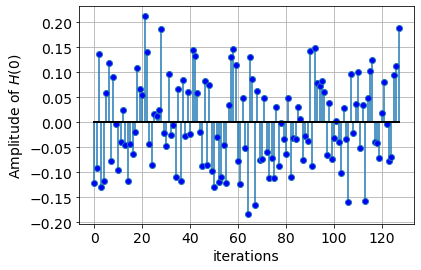

In [11]:
plt.figure()
t = np.arange(N)
markerline, stemlines, baseline = plt.stem(t,SystemResponse)
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'k', 'linewidth', 2),plt.grid()
plt.ylabel('Amplitude of $H(0)$', fontsize=14)
plt.xlabel('iterations', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Initialization of variables

In [12]:
#X0 = np.sqrt((1-alpha**2)*varx)*np.random.normal(0,1,size=iterations+N-1)
# Plotting the histogram of X0 if verification is necessary
#plt.hist(X0, bins=30, histtype='bar')

# Theoretical input autocorrelation matrix 

liner = np.array(varx*(alpha**(np.arange(N))))
# Input autocorrelation matrix
R = linalg.toeplitz(liner)

# Calculation of eigenvectors and eingenvalues
#   Each element of la is one eigenvalue (ordered by increasing magnitude)
#   Each column of S is an eigenvector in the same order
la, S = linalg.eigh(R)
#print("eigenvalues:",np.abs(la), '\n')
#print("eigenvectors: ", "\n", S, '\n')
spread = np.abs(np.max(la))/np.abs(np.min(la))
print('eigenvalue spread: ', spread)

# Input eigenvalue matrix
Lambda0 = np.diag(np.abs(la))      
#print("Lambda0 = ", '\n', Lambda0, '\n')

eigenvalue spread:  5.4402676581043625


### Monte Carlo (MC) Simulation

In [13]:
# Vector initializations
mse = np.zeros(iterations)            # Mean square error
emse = np.zeros(iterations)           # Excess mean square error
msd = np.zeros(iterations)            # Mean square deviation
msdtheo = np.zeros(iterations)        # Theoretical MSD(n)
emsetheo = np.zeros(iterations)        # Theoretical EMSE(n)
K0 = np.outer(SystemResponse,SystemResponse)  # Matrix K(0)

# Call function classical_model

msdtheo, emsetheo = classical_model(K0)
msdtheo = 10 * np.log10(msdtheo)
emsetheo = 10 * np.log10(emsetheo)

# Call function Monte Carlo realizations

#mse, emse, msd = Monte_Carlo(runs, SystemResponse, alpha, varx, varz, varq, N, iterations)
mse, emse, msd = Monte_Carlo(mse, emse, msd)

### Averaging

In [14]:
mse = mse/runs                                # evaluates MSE
emse = emse/runs                              # evaluates EMSE
msd = msd/runs                                # evaluates MSD
msedb = 10 * np.log10(mse)                    # MSE in dB
emsedb = 10 * np.log10(emse)                  # EMSE in dB
msddb = 10 * np.log10(msd)                    # MSD in dB

### Plotting the results

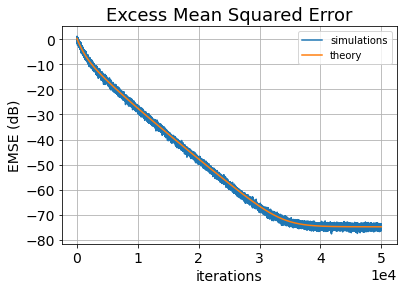

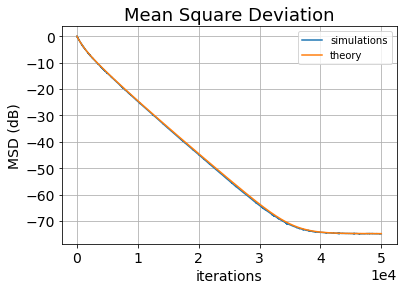

Duration:  0.40897939205169676 min
Duration:  24.538763523101807 s


In [15]:
plt.figure()
t = np.arange(iterations)
plt.plot(t,emsedb,label='simulations'), plt.grid()    
plt.plot(t,emsetheo,label='theory')  
#plt.plot(t,10*np.log10(Jex),label='theory model'),plt.grid()
plt.legend()                           # adds legend with labels defined above
plt.title('Excess Mean Squared Error', fontsize=18)
plt.xlabel('iterations', fontsize=14)
plt.ylabel('EMSE (dB)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax = plt.gca()                    # grabs current axes and names them ax
# Setting axes properties
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) # scientific number style
ax.xaxis.offsetText.set_fontsize(14)                        # offset text font size
#plt.savefig('testfig.pdf',bbox_inches='tight')
#plt.show()

plt.figure()
plt.plot(t,msddb,label='simulations'), plt.grid()    
plt.plot(t,msdtheo,label='theory')  
#plt.plot(t,10*np.log10(Jex),label='theory model'),plt.grid()
plt.legend()                           # adds legend with labels defined above
plt.title('Mean Square Deviation', fontsize=18)
plt.xlabel('iterations', fontsize=14)
plt.ylabel('MSD (dB)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax = plt.gca()                    # grabs current axes and names them ax
# Setting axes properties
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) # scientific number style
ax.xaxis.offsetText.set_fontsize(14)                        # offset text font size
#plt.savefig('testfig.pdf',bbox_inches='tight')
plt.show()

end_time = time.time()
print('Duration: ', (end_time - t0)/60,'min')
print('Duration: ', (end_time - t0),'s')